# Semana 2: Reproducción del baseline

## 1. Preprocesamiento de señales (filtrado, detección de picos R)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import wfdb
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from scipy import stats


In [2]:
# Detección de picos R en ECG con Python

# Read the file with all records
with open('data/training2017/RECORDS', 'r') as f:
    records = f.read().splitlines()

# Create a function to detect RR intervals
def detect_rr_intervals(signal, fs):
    peaks, _ = find_peaks(signal, height=np.mean(signal) + 0.5 * np.std(signal), distance=int(0.2 * fs))
    rr_intervals = np.diff(peaks) / fs
    return rr_intervals

# Create new DataFrame to store RR intervals for all records
rr_intervals_all = []

# Loop through each record and calculate RR intervals
for record_name in records:
    record = wfdb.rdrecord(f'data/training2017/{record_name}')
    signal = record.p_signal[:, 0]
    fs = record.fs
    rr_intervals = detect_rr_intervals(signal, fs)
    for interval in rr_intervals:
        rr_intervals_all.append((record_name, interval))

# Create a DataFrame for all RR intervals
rr_intervals_df = pd.DataFrame(rr_intervals_all, columns=['record', 'RR Interval (s)'])

# Print the summary of RR intervals
print("\nResumen de los intervalos RR para todos los registros:")
print(rr_intervals_df.describe())

# Save the RR intervals to a CSV file
rr_intervals_df.to_csv('data/rr_intervals.csv', index=False)




Resumen de los intervalos RR para todos los registros:
       RR Interval (s)
count    570411.000000
mean          0.476728
std           0.275231
min           0.200000
25%           0.263333
50%           0.413333
75%           0.633333
max          17.906667


## 2. Extracción de características (HRV, estadísticas)

In [3]:
# Calculate features from RR intervals

from scipy import stats

# Read the RR intervals from the CSV file
rr_intervals_df = pd.read_csv('data/rr_intervals.csv')

features = []

for record_name in rr_intervals_df['record'].unique():
    rr = rr_intervals_df[rr_intervals_df['record'] == record_name]['RR Interval (s)'].values
    if len(rr) > 1:
        features.append({
            'record': record_name,
            'mean_rr': np.mean(rr),
            'std_rr': np.std(rr),
            'skew_rr': stats.skew(rr),
            'kurt_rr': stats.kurtosis(rr)
        })

features_df = pd.DataFrame(features)
print(features_df.head())

# Save the features to a CSV file
features_df.to_csv('data/rr_features.csv', index=False)



   record   mean_rr    std_rr   skew_rr   kurt_rr
0  A00001  0.535988  0.224853 -0.261091 -1.533849
1  A00002  0.551235  0.284507  0.421827 -1.255844
2  A00003  0.578220  0.217038 -0.160148 -1.029851
3  A00004  0.475450  0.239311  0.735260 -0.724574
4  A00005  0.435450  0.203122  1.286421  1.256343


## 3. Entrenamiento del modelo baseline (Random Forest)

In [ ]:
# Cargar las características y las etiquetas
features_df_orig = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Normlizar las características

scaler = StandardScaler()
features_df = features_df_orig.copy()
features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']] = scaler.fit_transform(
    features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
)

# Unir características y etiquetas
data = features_df.merge(labels_df, on='record').dropna()

# Separar variables (X) y etiquetas (y)
X = data[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = data['label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Entrenar un modelo base (SVM)
clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train, y_train)



,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## 4. Evaluación simple (train/test o validación cruzada)

Métricas de desempeño del modelo SVM:
Accuracy:  0.5996
F1-Score:  0.4653
Precision: 0.5377
Recall:    0.5996

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00       148
           N       0.60      0.99      0.75      1010
           O       0.64      0.04      0.08       491
           ~       0.00      0.00      0.00        57

    accuracy                           0.60      1706
   macro avg       0.31      0.26      0.21      1706
weighted avg       0.54      0.60      0.47      1706



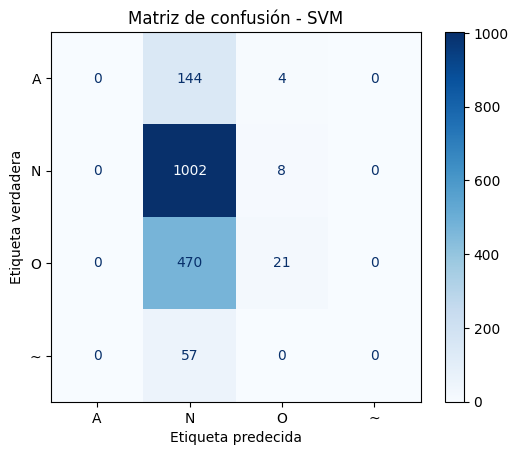

In [5]:
# Predecir sobre el conjunto de prueba
y_pred = clf.predict(X_test)

# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, zero_division=0))

# Visualización de la matriz de confusión
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM")
disp.ax_.set_xlabel('Etiqueta predecida')
disp.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


## 5. Conclusiones

- Dado que el modelo predice únicamente una etiqueta, debe haber un error en la fase de entrenamiento. Intentaré identificarlo y repararlo.
- UPDATE: Se detectó un problema en falta de estandarización de datos, la que fue agregada al procedimiento.
- UPDATE: Aún se detecta que no se detectan etiquetas 'A' ni '~', lo que sigue indicando un problema en la detección. Se probará modificando los parámetros en la detección de picos y otros modelos en la fase 3.

## 6. Trabajo para Informe Final

Este apartado es adicional sobre el trabajo de la semana 2 y se debe considerar como parte del trabajo para la entrega final.

### **Antes de examinar el código**

Es necesario destacar que para ejecutar el siguiente código, se debe antes ejecutar la primera celda de este cuadernillo, la que carga la mayoría de las librerías.

In [13]:
# El objetivo de esta sección es entrenar un modelo en base a un conjunto de datos usando solamente los datos correspondientes a etiquetas 'N' y 'A', para intentar maximizarla detección de arritmias.

# Cargar las características y las etiquetas
features_df_orig = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Normlizar las características
scaler = StandardScaler()
features_df = features_df_orig.copy()
features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']] = scaler.fit_transform(
    features_df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
)

# Unir características y etiquetas
data = features_df.merge(labels_df, on='record').dropna()

# Filtrar los datos para usar solo las etiquetas 'N' y 'A'
data_filtered = data[data['label'].isin(['N', 'A'])]
# Separar variables (X) y etiquetas (y)
X_filtered = data_filtered[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y_filtered = data_filtered['label']

# Dividir en conjunto de entrenamiento y prueba
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)
# Entrenar un modelo base (SVM) con los datos filtrados
clf_filtered = SVC(kernel='rbf', random_state=42)
clf_filtered.fit(X_train_filtered, y_train_filtered)





SVC(random_state=42)

Métricas de desempeño del modelo SVM (solo N y A):
Accuracy:  0.8765
F1-Score:  0.8244
Precision: 0.8741
Recall:    0.8765

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.86      0.04      0.08       148
           N       0.88      1.00      0.93      1010

    accuracy                           0.88      1158
   macro avg       0.87      0.52      0.51      1158
weighted avg       0.87      0.88      0.82      1158



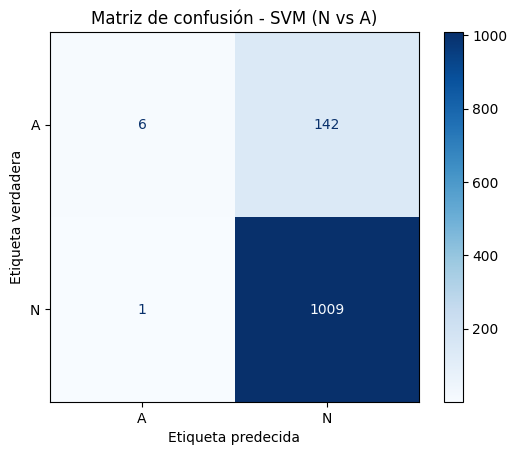

In [14]:
# Predecir sobre el conjunto de prueba filtrado y evaluar el modelo

# Predicción
y_pred_filtered = clf_filtered.predict(X_test_filtered)

# Calcular métricas de desempeño
accuracy_filtered = accuracy_score(y_test_filtered, y_pred_filtered)
f1_filtered = f1_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)
precision_filtered = precision_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)
recall_filtered = recall_score(y_test_filtered, y_pred_filtered, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM (solo N y A):")
print(f"Accuracy:  {accuracy_filtered:.4f}")
print(f"F1-Score:  {f1_filtered:.4f}")
print(f"Precision: {precision_filtered:.4f}")
print(f"Recall:    {recall_filtered:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_filtered, y_pred_filtered, zero_division=0))

# Visualización de la matriz de confusión
disp_filtered = ConfusionMatrixDisplay.from_estimator(clf_filtered, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM (N vs A)")
disp_filtered.ax_.set_xlabel('Etiqueta predecida')
disp_filtered.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


# Guardar las características filtradas
data_filtered.to_csv('data/rr_features_filtered_n_a.csv', index=False)



In [15]:
from imblearn.over_sampling import SMOTE

# Preparar más datos de arritmia para combatir el desbalance de clases, usando la técnica de SMOTE (Synthetic Minority Over-sampling Technique).


# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_filtered)

# Verificar el nuevo balance de clases
print("Distribución de clases después de SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Distribución de clases después de SMOTE:
label
N    4040
A    4040
Name: count, dtype: int64


Métricas de desempeño del modelo SVM balanceado:
Accuracy:  0.7314
F1-Score:  0.7749
Precision: 0.8889
Recall:    0.7314

Reporte de clasificación del modelo balanceado:
              precision    recall  f1-score   support

           A       0.31      0.87      0.45       148
           N       0.97      0.71      0.82      1010

    accuracy                           0.73      1158
   macro avg       0.64      0.79      0.64      1158
weighted avg       0.89      0.73      0.77      1158



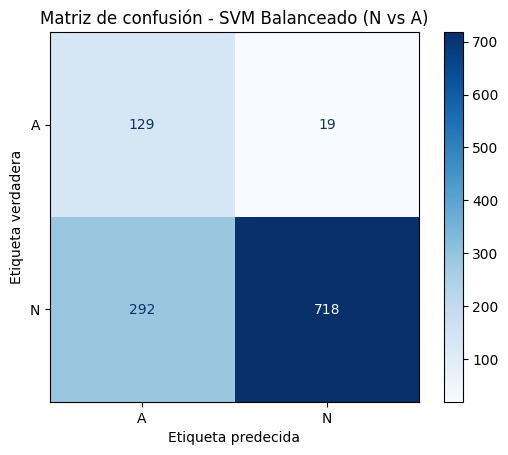

In [16]:
# Entrenar un nuevo modelo SVM con los datos balanceados
clf_balanced = SVC(kernel='rbf', random_state=42)
clf_balanced.fit(X_train_resampled, y_train_resampled)

# Predecir sobre el conjunto de prueba con el modelo balanceado
y_pred_balanced = clf_balanced.predict(X_test_filtered)

# Calcular métricas de desempeño del modelo balanceado
accuracy_balanced = accuracy_score(y_test_filtered, y_pred_balanced)
print("Métricas de desempeño del modelo SVM balanceado:")
print(f"Accuracy:  {accuracy_balanced:.4f}")
f1_balanced = f1_score(y_test_filtered, y_pred_balanced, average='weighted', zero_division=0)
print(f"F1-Score:  {f1_balanced:.4f}")
precision_balanced = precision_score(y_test_filtered, y_pred_balanced, average='weighted', zero_division=0)
print(f"Precision: {precision_balanced:.4f}")
recall_balanced = recall_score(y_test_filtered, y_pred_balanced, average='weighted', zero_division=0)
print(f"Recall:    {recall_balanced:.4f}")
print("\nReporte de clasificación del modelo balanceado:")
print(classification_report(y_test_filtered, y_pred_balanced, zero_division=0))

# Visualización de la matriz de confusión del modelo balanceado
disp_balanced = ConfusionMatrixDisplay.from_estimator(clf_balanced, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM Balanceado (N vs A)")
disp_balanced.ax_.set_xlabel('Etiqueta predecida')
disp_balanced.ax_.set_ylabel('Etiqueta verdadera')
plt.show()




Resumen de las predicciones para los datos 'O':
predicted_label
N    1313
A    1143
Name: count, dtype: int64


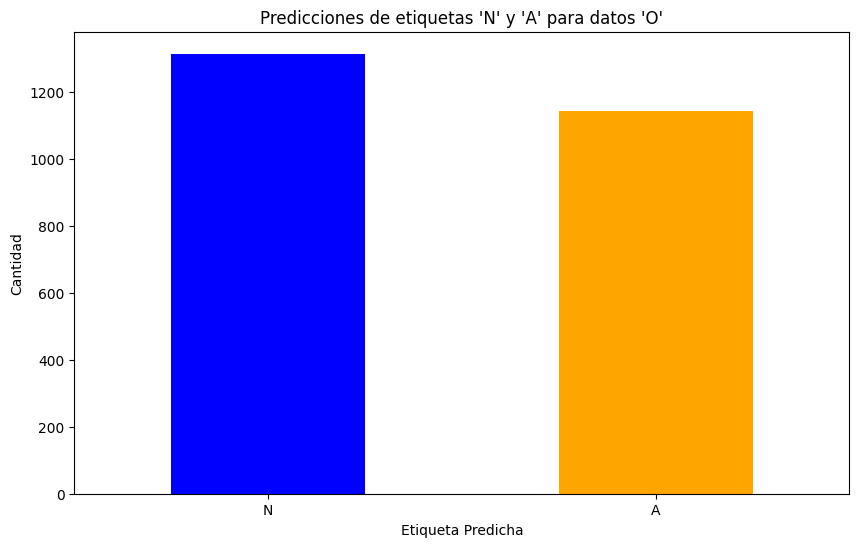

In [17]:
# Ahora, se engañará al modelo para que prediga sobre los datos 'O' como si fueran 'N' o 'A', para ver si el modelo puede detectar arritmias en los datos de referencia.

# Cargar las características y las etiquetas de los datos de referencia
features_df_orig = pd.read_csv('data/rr_features.csv')
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Filtrar los datos para usar solo las etiquetas 'O'
data_orig = features_df_orig.merge(labels_df, on='record').dropna()
data_o = data_orig[data_orig['label'] == 'O'].copy()

# Normalizar las características de los datos 'O'
data_o.loc[:, ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']] = scaler.transform(
    data_o[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
)

# Preparar los datos 'O' para la predicción
X_o = data_o[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]

# Predecir las etiquetas 'N' o 'A' para los datos 'O'
y_pred_o = clf_balanced.predict(X_o)

# Agregar las predicciones al DataFrame de datos 'O'
data_o['predicted_label'] = y_pred_o

# Guardar las predicciones de los datos 'O'
data_o.to_csv('data/rr_features_predicted_o.csv', index=False)

# Mostrar un resumen de las predicciones
print("\nResumen de las predicciones para los datos 'O':")
print(data_o['predicted_label'].value_counts())

# Visualizar las predicciones de los datos 'O'
plt.figure(figsize=(10, 6))
data_o['predicted_label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Predicciones de etiquetas 'N' y 'A' para datos 'O'")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Cantidad")
plt.xticks(rotation=0)
plt.show()



Métricas de desempeño del modelo SVM con datos 'O' como 'N':
Accuracy:  0.8066
F1-Score:  0.8288
Precision: 0.8690
Recall:    0.8066

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.36      0.66      0.47       148
           N       0.94      0.83      0.88      1010

    accuracy                           0.81      1158
   macro avg       0.65      0.74      0.67      1158
weighted avg       0.87      0.81      0.83      1158



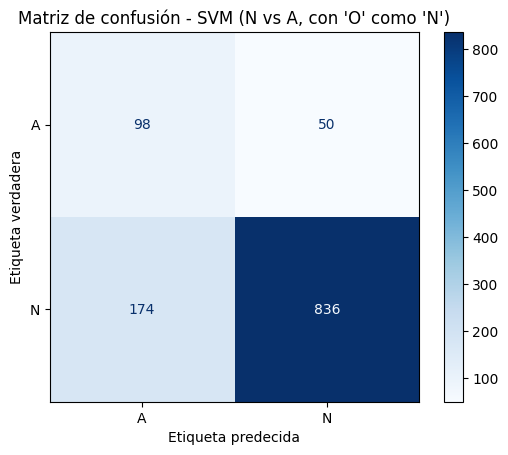

In [18]:
# El siguiente paso es entrenar el modelo con los datos 'O' como si fueran 'N' para intentar mejorar la precisión del modelo.

# Dividir data_o en entrenamiento y prueba
X_o_train, X_o_test = train_test_split(X_o, test_size=0.2, random_state=42, stratify=None)

# Crear etiquetas 'N' para los datos 'O'
y_o_train = pd.Series(['N'] * len(X_o_train), index=X_o_train.index)
y_o_test = pd.Series(['N'] * len(X_o_test), index=X_o_test.index)

# Unir los datos 'O' de entrenamiento a los datos balanceados originales
X_train_augmented = pd.concat([X_train_resampled, X_o_train], ignore_index=True)
y_train_augmented = pd.concat([y_train_resampled, y_o_train], ignore_index=True)


# Entrenar un nuevo modelo SVM con los datos aumentados
clf_augmented = SVC(kernel='rbf', random_state=42)
clf_augmented.fit(X_train_augmented, y_train_augmented)

# Predecir sobre el conjunto de prueba original (N vs A)
y_pred_augmented = clf_augmented.predict(X_test_filtered)

# Calcular métricas de desempeño
accuracy_augmented = accuracy_score(y_test_filtered, y_pred_augmented)
f1_augmented = f1_score(y_test_filtered, y_pred_augmented, average='weighted', zero_division=0)
precision_augmented = precision_score(y_test_filtered, y_pred_augmented, average='weighted', zero_division=0)
recall_augmented = recall_score(y_test_filtered, y_pred_augmented, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVM con datos 'O' como 'N':")
print(f"Accuracy:  {accuracy_augmented:.4f}")
print(f"F1-Score:  {f1_augmented:.4f}")
print(f"Precision: {precision_augmented:.4f}")
print(f"Recall:    {recall_augmented:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_filtered, y_pred_augmented, zero_division=0))

# Visualización de la matriz de confusión
disp_augmented = ConfusionMatrixDisplay.from_estimator(clf_augmented, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM (N vs A, con 'O' como 'N')")
disp_augmented.ax_.set_xlabel('Etiqueta predecida')
disp_augmented.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


Distribución de clases después de SMOTE en datos aumentados:
N    6004
A    6004
Name: count, dtype: int64
Métricas de desempeño del modelo SVM balanceado con datos 'O' como 'N':
Accuracy:  0.7271
F1-Score:  0.7711
Precision: 0.8821
Recall:    0.7271

Reporte de clasificación del modelo balanceado con datos 'O' como 'N':
              precision    recall  f1-score   support

           A       0.30      0.84      0.44       148
           N       0.97      0.71      0.82      1010

    accuracy                           0.73      1158
   macro avg       0.63      0.77      0.63      1158
weighted avg       0.88      0.73      0.77      1158



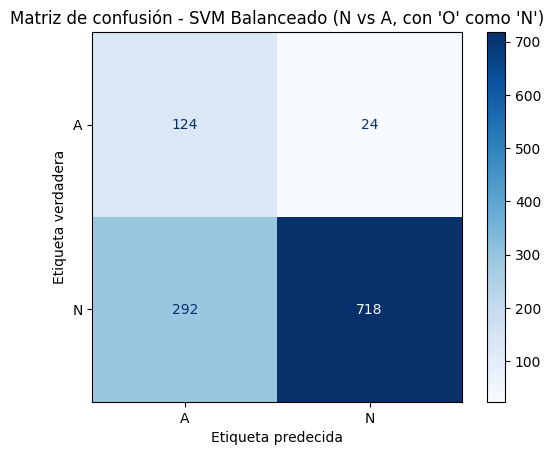

In [19]:
# Por último, se hará un nuevo rebalance de los datos aumentados y se reentrenará el modelo para ver si se mejora la precisión.

# Aplicar SMOTE a los datos aumentados
smote_augmented = SMOTE(random_state=42)
X_train_aug_resampled, y_train_aug_resampled = smote_augmented.fit_resample(X_train_augmented, y_train_augmented)

# Verificar el nuevo balance de clases
print("Distribución de clases después de SMOTE en datos aumentados:")
print(pd.Series(y_train_aug_resampled).value_counts())

# Reentrenar el modelo con los datos aumentados y balanceados
clf_augmented = SVC(kernel='rbf', random_state=42)
clf_augmented.fit(X_train_aug_resampled, y_train_aug_resampled)

# Predecir sobre el conjunto de prueba original (N vs A) con el modelo balanceado
y_pred_aug_resampled = clf_augmented.predict(X_test_filtered)

# Calcular métricas de desempeño del modelo balanceado
accuracy_aug_resampled = accuracy_score(y_test_filtered, y_pred_aug_resampled)
f1_aug_resampled = f1_score(y_test_filtered, y_pred_aug_resampled, average='weighted', zero_division=0)
precision_aug_resampled = precision_score(y_test_filtered, y_pred_aug_resampled, average='weighted', zero_division=0)
recall_aug_resampled = recall_score(y_test_filtered, y_pred_aug_resampled, average='weighted', zero_division=0)
print("Métricas de desempeño del modelo SVM balanceado con datos 'O' como 'N':")
print(f"Accuracy:  {accuracy_aug_resampled:.4f}")
print(f"F1-Score:  {f1_aug_resampled:.4f}")
print(f"Precision: {precision_aug_resampled:.4f}")
print(f"Recall:    {recall_aug_resampled:.4f}")
print("\nReporte de clasificación del modelo balanceado con datos 'O' como 'N':")
print(classification_report(y_test_filtered, y_pred_aug_resampled, zero_division=0))

# Visualización de la matriz de confusión del modelo balanceado con datos 'O' como 'N'
disp_aug_resampled = ConfusionMatrixDisplay.from_estimator(clf_augmented, X_test_filtered, y_test_filtered, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVM Balanceado (N vs A, con 'O' como 'N')")
disp_aug_resampled.ax_.set_xlabel('Etiqueta predecida')
disp_aug_resampled.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


## 7. Reajustes finales

Se realizarán los procesos anteriores bajo diferentes condiciones para intentar mejorar el rendimiento del modelo. Los cambios a realizar son:
- Realizar la identificación de intervalos para transformar el dataset directamente con la librería `wfdb`.
- Probar un modelo Random Forest en lugar de SVC.
- Recortar la duración que se toma de las señales (opcional).

In [3]:
# Transformación de los datos RR usando la librería WFDB
# Para comparar los resultados con la librería WFDB, se utilizará la función gqrs_detect de la librería wfdb.processing, que es una implementación de un detector de picos R.

from wfdb.processing import gqrs_detect

with open('data/training2017/RECORDS', 'r') as f:
    records = f.read().splitlines()

rr_intervals_all_wfdb = []

for record_name in records:
    record = wfdb.rdrecord(f'data/training2017/{record_name}')
    signal = record.p_signal[:, 0]
    fs = record.fs
    # Detección de picos R usando wfdb.processing.gqrs_detect
    r_peaks = gqrs_detect(sig=signal, fs=fs)
    rr_intervals = np.diff(r_peaks) / fs
    for interval in rr_intervals:
        rr_intervals_all_wfdb.append((record_name, interval))

rr_intervals_wfdb_df = pd.DataFrame(rr_intervals_all_wfdb, columns=['record', 'RR Interval (s)'])
rr_intervals_wfdb_df.to_csv('data/rr_intervals_WFDB.csv', index=False)


   record  RR Interval (s)
0  A00001         0.713333
1  A00001         0.726667
2  A00001         0.790000
3  A00001         0.810000
4  A00001         0.770000


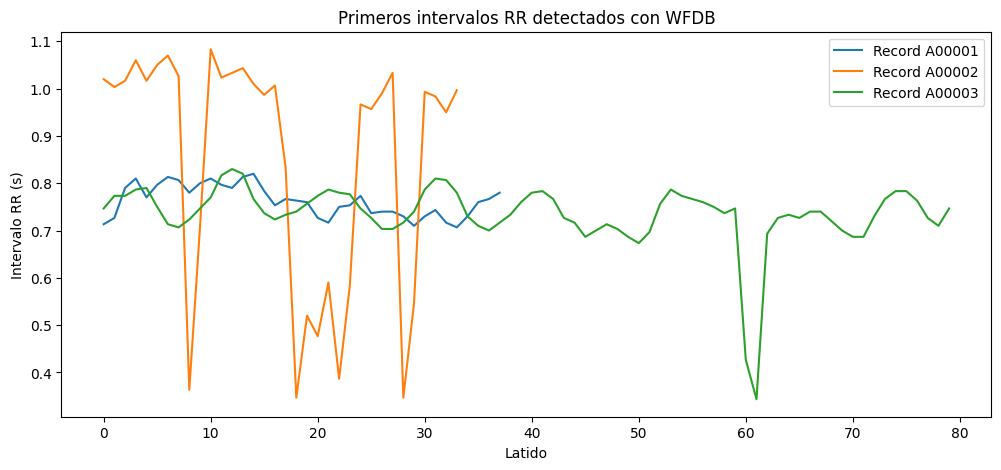

In [4]:
# Visualizar los resultados de la detección de picos R usando WFDB
# Cargar el archivo de intervalos RR detectados con WFDB
rr_intervals_wfdb_df = pd.read_csv('data/rr_intervals_WFDB.csv')

# Visualizar en texto los primeros datos
print(rr_intervals_wfdb_df.head())

# Graficar los primeros 200 intervalos RR de los primeros 3 registros
plt.figure(figsize=(12, 5))
for record_id in rr_intervals_wfdb_df['record'].unique()[:3]:
    rr_vals = rr_intervals_wfdb_df[rr_intervals_wfdb_df['record'] == record_id]['RR Interval (s)'].values[:200]
    plt.plot(rr_vals, label=f'Record {record_id}')
plt.xlabel('Latido')
plt.ylabel('Intervalo RR (s)')
plt.title('Primeros intervalos RR detectados con WFDB')
plt.legend()
plt.show()

In [5]:
# Crear un DataFrame para las características de los intervalos RR detectados con WFDB
features_wfdb = []

for record_name in rr_intervals_wfdb_df['record'].unique():
    rr = rr_intervals_wfdb_df[rr_intervals_wfdb_df['record'] == record_name]['RR Interval (s)'].values
    if len(rr) > 1:
        features_wfdb.append({
            'record': record_name,
            'mean_rr': np.mean(rr),
            'std_rr': np.std(rr),
            'skew_rr': stats.skew(rr),
            'kurt_rr': stats.kurtosis(rr)
        })

features_wfdb_df = pd.DataFrame(features_wfdb)
print(features_wfdb_df.head())

# Guardar las características de los intervalos RR detectados con WFDB
features_wfdb_df.to_csv('data/rr_features_WFDB.csv', index=False)


   record   mean_rr    std_rr   skew_rr    kurt_rr
0  A00001  0.762456  0.033269  0.056302  -1.189458
1  A00002  0.853529  0.248621 -1.020497  -0.624117
2  A00003  0.735417  0.066515 -3.665122  18.129292
3  A00004  0.942258  0.177819  0.535841  -0.886063
4  A00005  0.538593  0.220119  1.213568   0.137844


In [7]:
# Realizar entrenamiento de un modelo random forest con las características de los intervalos RR detectados con WFDB
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Cargar las etiquetas originales
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Unir características y etiquetas usando las nuevas características de WFDB
data_wfdb = features_wfdb_df.merge(labels_df, on='record').dropna()

# Filtrar los datos para ignorar las etiquetas '~'
data_wfdb = data_wfdb[data_wfdb['label'] != '~']

# Convertir las etiquetas 'O' a 'N'
data_wfdb['label'] = data_wfdb['label'].replace('O', 'N')

# Separar variables (X) y etiquetas (y)
X_wfdb = data_wfdb[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y_wfdb = data_wfdb['label']

# Estandarizar las características
scaler_wfdb = StandardScaler()
X_wfdb_scaled = scaler_wfdb.fit_transform(X_wfdb)

# Dividir en conjunto de entrenamiento y prueba
X_train_wfdb, X_test_wfdb, y_train_wfdb, y_test_wfdb = train_test_split(
    X_wfdb_scaled, y_wfdb, test_size=0.2, random_state=42, stratify=y_wfdb
)

# Aplicar SMOTE solo al conjunto de entrenamiento para balancear la clase 'A'
smote = SMOTE(random_state=42)
X_train_wfdb_res, y_train_wfdb_res = smote.fit_resample(X_train_wfdb, y_train_wfdb)

# Verificar el nuevo balance de clases
print("Distribución de clases después de SMOTE (entrenamiento):")
print(pd.Series(y_train_wfdb_res).value_counts())

# Entrenar el modelo Random Forest con los datos balanceados
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_wfdb_res, y_train_wfdb_res)

Distribución de clases después de SMOTE (entrenamiento):
label
N    6005
A    6005
Name: count, dtype: int64


RandomForestClassifier(random_state=42)

Métricas de desempeño del modelo Random Forest (WFDB):
Accuracy:  0.9309
F1-Score:  0.9354
Precision: 0.9433
Recall:    0.9309

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.58      0.79      0.67       148
           N       0.98      0.94      0.96      1501

    accuracy                           0.93      1649
   macro avg       0.78      0.87      0.82      1649
weighted avg       0.94      0.93      0.94      1649



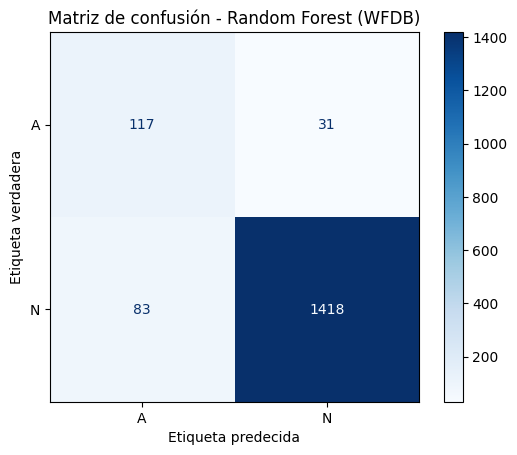

In [8]:
# Evaluar el modelo

# Predecir sobre el conjunto de prueba
y_pred_wfdb = rf_clf.predict(X_test_wfdb)

# Calcular métricas de desempeño
accuracy_wfdb = accuracy_score(y_test_wfdb, y_pred_wfdb)
f1_wfdb = f1_score(y_test_wfdb, y_pred_wfdb, average='weighted', zero_division=0)
precision_wfdb = precision_score(y_test_wfdb, y_pred_wfdb, average='weighted', zero_division=0)
recall_wfdb = recall_score(y_test_wfdb, y_pred_wfdb, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo Random Forest (WFDB):")
print(f"Accuracy:  {accuracy_wfdb:.4f}")
print(f"F1-Score:  {f1_wfdb:.4f}")
print(f"Precision: {precision_wfdb:.4f}")
print(f"Recall:    {recall_wfdb:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_wfdb, y_pred_wfdb, zero_division=0))

# Visualización de la matriz de confusión
disp_rf = ConfusionMatrixDisplay.from_estimator(rf_clf, X_test_wfdb, y_test_wfdb, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Random Forest (WFDB)")
disp_rf.ax_.set_xlabel('Etiqueta predecida')
disp_rf.ax_.set_ylabel('Etiqueta verdadera')
plt.show()

Métricas de desempeño del modelo SVC (WFDB):
Accuracy:  0.9090
F1-Score:  0.9209
Precision: 0.9482
Recall:    0.9090

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.50      0.93      0.65       148
           N       0.99      0.91      0.95      1501

    accuracy                           0.91      1649
   macro avg       0.74      0.92      0.80      1649
weighted avg       0.95      0.91      0.92      1649



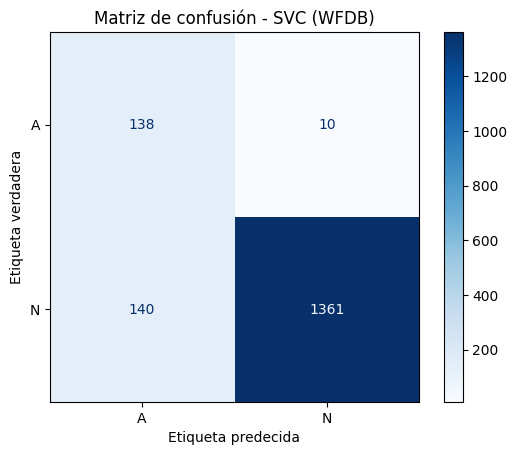

In [9]:
# Probar el modelo SVC con los datos de WFDB

# Entrenar el modelo SVC con los datos de WFDB balanceados
svc_wfdb = SVC(kernel='rbf', random_state=42)
svc_wfdb.fit(X_train_wfdb_res, y_train_wfdb_res)

# Predecir sobre el conjunto de prueba
y_pred_svc_wfdb = svc_wfdb.predict(X_test_wfdb)

# Calcular métricas de desempeño
accuracy_svc_wfdb = accuracy_score(y_test_wfdb, y_pred_svc_wfdb)
f1_svc_wfdb = f1_score(y_test_wfdb, y_pred_svc_wfdb, average='weighted', zero_division=0)
precision_svc_wfdb = precision_score(y_test_wfdb, y_pred_svc_wfdb, average='weighted', zero_division=0)
recall_svc_wfdb = recall_score(y_test_wfdb, y_pred_svc_wfdb, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVC (WFDB):")
print(f"Accuracy:  {accuracy_svc_wfdb:.4f}")
print(f"F1-Score:  {f1_svc_wfdb:.4f}")
print(f"Precision: {precision_svc_wfdb:.4f}")
print(f"Recall:    {recall_svc_wfdb:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_wfdb, y_pred_svc_wfdb, zero_division=0))

# Visualización de la matriz de confusión
disp_svc_wfdb = ConfusionMatrixDisplay.from_estimator(svc_wfdb, X_test_wfdb, y_test_wfdb, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVC (WFDB)")
disp_svc_wfdb.ax_.set_xlabel('Etiqueta predecida')
disp_svc_wfdb.ax_.set_ylabel('Etiqueta verdadera')
plt.show()

### Focalización

A continuación, se intentará enfocar los datos en las secciones que son más significativas para cada señal ECG.

El procedimiento ideado es identificar la sección más 'caótica' de cada señal ECG y agregar sus características aisladas a las características correspondientes a cada lectura.

In [2]:
# Cargar los intervalos RR detectados con WFDB
rr_intervals_wfdb_df = pd.read_csv('data/rr_intervals_WFDB.csv')

# Definir función para extraer la sección más 'caótica' (mayor std) de cada señal
def extract_chaos_features(rr_intervals, window_size=30):
    if len(rr_intervals) < window_size:
        return np.nan, np.nan, np.nan, np.nan
    max_std = -np.inf
    chaos_idx = 0
    for i in range(len(rr_intervals) - window_size + 1):
        window = rr_intervals[i:i+window_size]
        std = np.std(window)
        if std > max_std:
            max_std = std
            chaos_idx = i
    chaos_window = rr_intervals[chaos_idx:chaos_idx+window_size]
    return (
        np.mean(chaos_window),
        np.std(chaos_window),
        stats.skew(chaos_window),
        stats.kurtosis(chaos_window)
    )

# Cargar las features globales ya calculadas
features_wfdb_df = pd.read_csv('data/rr_features_WFDB.csv')

# Calcular features de la sección más caótica y agregarlas al DataFrame
features_chaos = []
window_size = 30  # puedes ajustar este valor

for record_name in features_wfdb_df['record']:
    rr = rr_intervals_wfdb_df[rr_intervals_wfdb_df['record'] == record_name]['RR Interval (s)'].values
    mean_chaos, std_chaos, skew_chaos, kurt_chaos = extract_chaos_features(rr, window_size)
    features_chaos.append({
        'mean_rr_chaos': mean_chaos,
        'std_rr_chaos': std_chaos,
        'skew_rr_chaos': skew_chaos,
        'kurt_rr_chaos': kurt_chaos
    })

features_chaos_df = pd.DataFrame(features_chaos)
features_chaos_df['record'] = features_wfdb_df['record']

# Unir las features globales y las de la sección caótica
features_full_df = features_wfdb_df.merge(features_chaos_df, on='record')

# Guardar el nuevo archivo
features_full_df.to_csv('data/rr_features_chaos.csv', index=False)
print(features_full_df.head())

   record   mean_rr    std_rr   skew_rr    kurt_rr  mean_rr_chaos  \
0  A00001  0.762456  0.033269  0.056302  -1.189458       0.761889   
1  A00002  0.853529  0.248621 -1.020497  -0.624117       0.836556   
2  A00003  0.735417  0.066515 -3.665122  18.129292       0.713889   
3  A00004  0.942258  0.177819  0.535841  -0.886063       0.942000   
4  A00005  0.538593  0.220119  1.213568   0.137844       0.568778   

   std_rr_chaos  skew_rr_chaos  kurt_rr_chaos  
0      0.034131       0.141164      -1.247405  
1      0.259922      -0.832587      -0.997622  
2      0.094888      -2.797914       7.637788  
3      0.180753       0.531458      -0.950974  
4      0.252430       0.856119      -0.846303  


In [10]:
from sklearn.ensemble import RandomForestClassifier
# Cargar las etiquetas originales
labels_df = pd.read_csv('data/training2017/REFERENCE.csv', header=None, names=['record', 'label'])

# Unir características y etiquetas usando las nuevas características con caos
data_chaos = features_full_df.merge(labels_df, on='record').dropna()

# Filtrar los datos para ignorar las etiquetas '~'
data_chaos = data_chaos[data_chaos['label'] != '~']

# Convertir las etiquetas 'O' a 'N'
data_chaos['label'] = data_chaos['label'].replace('O', 'N')

# Seleccionar las características (incluyendo las de caos)
feature_cols = [
    'mean_rr', 'std_rr', 'skew_rr', 'kurt_rr',
    'mean_rr_chaos', 'std_rr_chaos', 'skew_rr_chaos', 'kurt_rr_chaos'
]
X_chaos = data_chaos[feature_cols]
y_chaos = data_chaos['label']

# Estandarizar las características
scaler_chaos = StandardScaler()
X_chaos_scaled = scaler_chaos.fit_transform(X_chaos)

# Dividir en conjunto de entrenamiento y prueba
X_train_chaos, X_test_chaos, y_train_chaos, y_test_chaos = train_test_split(
    X_chaos_scaled, y_chaos, test_size=0.2, random_state=42, stratify=y_chaos
)

# Balancear la clase 'A' usando SMOTE
smote = SMOTE(random_state=42)
X_train_chaos_res, y_train_chaos_res = smote.fit_resample(X_train_chaos, y_train_chaos)

# Entrenar el modelo Random Forest
rf_clf_chaos = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_chaos.fit(X_train_chaos_res, y_train_chaos_res)

RandomForestClassifier(random_state=42)

Métricas de desempeño del modelo Random Forest (con features de caos):
Accuracy:  0.9196
F1-Score:  0.9257
Precision: 0.9363
Recall:    0.9196

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.55      0.78      0.64       117
           N       0.98      0.93      0.95      1139

    accuracy                           0.92      1256
   macro avg       0.76      0.86      0.80      1256
weighted avg       0.94      0.92      0.93      1256



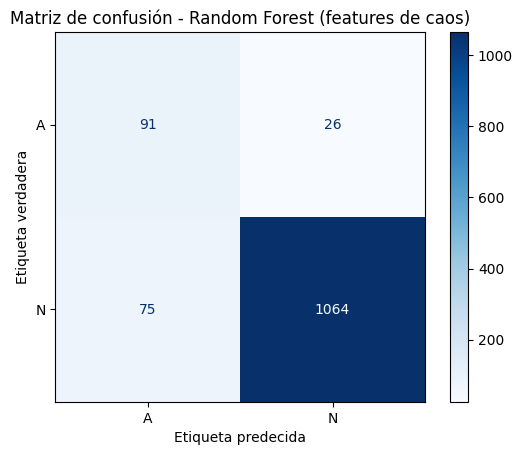

In [11]:
# Predecir sobre el conjunto de prueba
y_pred_chaos = rf_clf_chaos.predict(X_test_chaos)

# Calcular métricas de desempeño
accuracy_chaos = accuracy_score(y_test_chaos, y_pred_chaos)
f1_chaos = f1_score(y_test_chaos, y_pred_chaos, average='weighted', zero_division=0)
precision_chaos = precision_score(y_test_chaos, y_pred_chaos, average='weighted', zero_division=0)
recall_chaos = recall_score(y_test_chaos, y_pred_chaos, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo Random Forest (con features de caos):")
print(f"Accuracy:  {accuracy_chaos:.4f}")
print(f"F1-Score:  {f1_chaos:.4f}")
print(f"Precision: {precision_chaos:.4f}")
print(f"Recall:    {recall_chaos:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_chaos, y_pred_chaos, zero_division=0))

# Visualización de la matriz de confusión
disp_chaos = ConfusionMatrixDisplay.from_estimator(rf_clf_chaos, X_test_chaos, y_test_chaos, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Random Forest (features de caos)")
disp_chaos.ax_.set_xlabel('Etiqueta predecida')
disp_chaos.ax_.set_ylabel('Etiqueta verdadera')
plt.show()


Métricas de desempeño del modelo SVC (con features de caos):
Accuracy:  0.8989
F1-Score:  0.9118
Precision: 0.9399
Recall:    0.8989

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.48      0.89      0.62       117
           N       0.99      0.90      0.94      1139

    accuracy                           0.90      1256
   macro avg       0.73      0.89      0.78      1256
weighted avg       0.94      0.90      0.91      1256



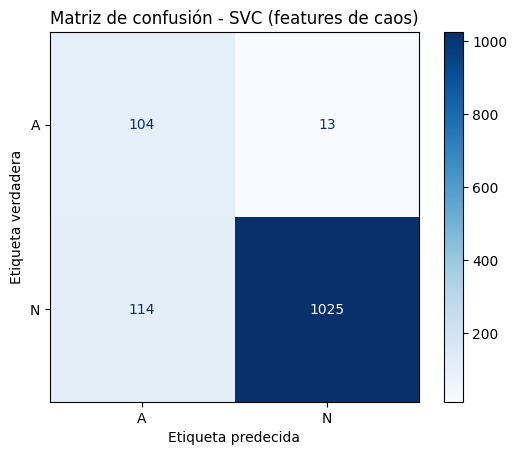

In [12]:
# Entrenar el modelo SVC con las características de caos y datos balanceados
svc_clf_chaos = SVC(kernel='rbf', random_state=42)
svc_clf_chaos.fit(X_train_chaos_res, y_train_chaos_res)

# Predecir sobre el conjunto de prueba
y_pred_svc_chaos = svc_clf_chaos.predict(X_test_chaos)

# Calcular métricas de desempeño
accuracy_svc_chaos = accuracy_score(y_test_chaos, y_pred_svc_chaos)
f1_svc_chaos = f1_score(y_test_chaos, y_pred_svc_chaos, average='weighted', zero_division=0)
precision_svc_chaos = precision_score(y_test_chaos, y_pred_svc_chaos, average='weighted', zero_division=0)
recall_svc_chaos = recall_score(y_test_chaos, y_pred_svc_chaos, average='weighted', zero_division=0)

print("Métricas de desempeño del modelo SVC (con features de caos):")
print(f"Accuracy:  {accuracy_svc_chaos:.4f}")
print(f"F1-Score:  {f1_svc_chaos:.4f}")
print(f"Precision: {precision_svc_chaos:.4f}")
print(f"Recall:    {recall_svc_chaos:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test_chaos, y_pred_svc_chaos, zero_division=0))

# Visualización de la matriz de confusión
disp_svc_chaos = ConfusionMatrixDisplay.from_estimator(svc_clf_chaos, X_test_chaos, y_test_chaos, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - SVC (features de caos)")
disp_svc_chaos.ax_.set_xlabel('Etiqueta predecida')
disp_svc_chaos.ax_.set_ylabel('Etiqueta verdadera')
plt.show()

In [13]:
# Se guardarán los resultados de los modelos en un DataFrame y se exportarán a un archivo CSV.

from sklearn.metrics import classification_report

# Obtener los reports como diccionario
report_rf_wfdb = classification_report(y_test_wfdb, y_pred_wfdb, output_dict=True, zero_division=0)
report_svc_wfdb = classification_report(y_test_wfdb, y_pred_svc_wfdb, output_dict=True, zero_division=0)
report_rf_chaos = classification_report(y_test_chaos, y_pred_chaos, output_dict=True, zero_division=0)
report_svc_chaos = classification_report(y_test_chaos, y_pred_svc_chaos, output_dict=True, zero_division=0)

results = [
    {
        'modelo': 'RandomForest',
        'accuracy': accuracy_wfdb,
        'f1_score': f1_wfdb,
        'precision': precision_wfdb,
        'recall': recall_wfdb,
        'precision_A': report_rf_wfdb['A']['precision'],
        'recall_A': report_rf_wfdb['A']['recall'],
        'f1_score_A': report_rf_wfdb['A']['f1-score'],
        'support_A': report_rf_wfdb['A']['support']
    },
    {
        'modelo': 'SVC',
        'accuracy': accuracy_svc_wfdb,
        'f1_score': f1_svc_wfdb,
        'precision': precision_svc_wfdb,
        'recall': recall_svc_wfdb,
        'precision_A': report_svc_wfdb['A']['precision'],
        'recall_A': report_svc_wfdb['A']['recall'],
        'f1_score_A': report_svc_wfdb['A']['f1-score'],
        'support_A': report_svc_wfdb['A']['support']
    },
    {
        'modelo': 'RandomForest (chaos)',
        'accuracy': accuracy_chaos,
        'f1_score': f1_chaos,
        'precision': precision_chaos,
        'recall': recall_chaos,
        'precision_A': report_rf_chaos['A']['precision'],
        'recall_A': report_rf_chaos['A']['recall'],
        'f1_score_A': report_rf_chaos['A']['f1-score'],
        'support_A': report_rf_chaos['A']['support']
    },
    {
        'modelo': 'SVC (chaos)',
        'accuracy': accuracy_svc_chaos,
        'f1_score': f1_svc_chaos,
        'precision': precision_svc_chaos,
        'recall': recall_svc_chaos,
        'precision_A': report_svc_chaos['A']['precision'],
        'recall_A': report_svc_chaos['A']['recall'],
        'f1_score_A': report_svc_chaos['A']['f1-score'],
        'support_A': report_svc_chaos['A']['support']
    }
]

results_df = pd.DataFrame(results)
results_df.to_csv('resultados.csv', index=False)
print(results_df)

                 modelo  accuracy  f1_score  precision    recall  precision_A  \
0          RandomForest  0.930867  0.935423   0.943279  0.930867     0.585000   
1                   SVC  0.909036  0.920857   0.948162  0.909036     0.496403   
2  RandomForest (chaos)  0.919586  0.925664   0.936282  0.919586     0.548193   
3           SVC (chaos)  0.898885  0.911782   0.939930  0.898885     0.477064   

   recall_A  f1_score_A  support_A  
0  0.790541    0.672414      148.0  
1  0.932432    0.647887      148.0  
2  0.777778    0.643110      117.0  
3  0.888889    0.620896      117.0  


### Observaciones

- Las métricas favorecen a los análisis con datos originales por sobre los que agregan estadísticas de caos.
- SVC es el modelo que capta más arritmias (basado en `recall_A`).
- RandomForest es el modelo que alza menos falsos positivos (basado en `precision_A`).
- El modelo con mayor `accurracy` es RandomForest, llevando una exactitud mayor al 93%.

### Conclusiones

- El método utilizado para enfocarse en las regiones caóticas no tuvo el efecto esperado para mejorar la calidad de las predicciones de cada modelo. Tal vez refinamiento a futuro pueda mejorar el desempeño de esta idea.
- El modelo SVC detectó la mayor cantidad de arritmias reales, sin embargo, alza una gran cantidad de falsos positivos. RandomForest tuvo una exactitud alta en general y mayor confiabilidad al predecir casos de arritmia. Como se busca la más alta detección de arritmias reales, el modelo SVC puede ser aquél que resulte más útil para este caso, pero la confiabilidad significativamente más alta del modelo entrenado RandomForest por una pérdida no tan significativa en la detección de casos reales, parece ser a mi juicio el modelo con mejores resultados.